# pzflow

In this notebook we show how we can use the [pzflow package](https://jfcrenshaw.github.io/pzflow/) to generate data from joint distributions that have been learned from real data. Sampling with `pzflow` creates Pandas tables of values.

Note that the [pzflow package](https://jfcrenshaw.github.io/pzflow/) is not installed as part of the default TDAstro installation. Users will need to manually install pzflow via pip (e.g. `pip install pzflow`) in order to run this notebook.

We start by generating a toy model (not physically based) of _brightness_ as dependent on _redshift_, where the _brightness_ is drawn as a Gaussian with the mean = 10.0 + 2.0 / _redshift_ and the standard deviation = 0.5/_redshift_. This toy distribution gives us something we can easily visualize and reason about. 

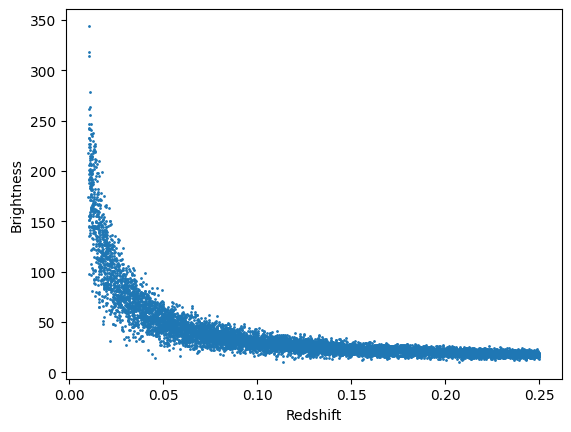

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pzflow import Flow

# Generate the data to use for training the flow model.
num_samples = 10_000
redshift = np.random.uniform(0.01, 0.25, size=num_samples)
brightness = np.random.normal(loc=(10.0 + 2.0 / redshift), scale=0.5 / redshift, size=num_samples)

plt.scatter(redshift, brightness, s=1)
plt.xlabel("Redshift")
plt.ylabel("Brightness")
plt.show()

We can train a pzflow model based on this toy distribution by: 1) putting the data into a Pandas DataFrame, 2) creating a flow object that tells it which columns to model, and 3) using the `train` function.

In [2]:
data = pd.DataFrame({"redshift": redshift, "brightness": brightness})
flow = Flow(["brightness", "redshift"])
losses = flow.train(data, verbose=False)

The `Flow` object is now a model of the distribution. We can sample new observations from the flow using its `sample()` method.

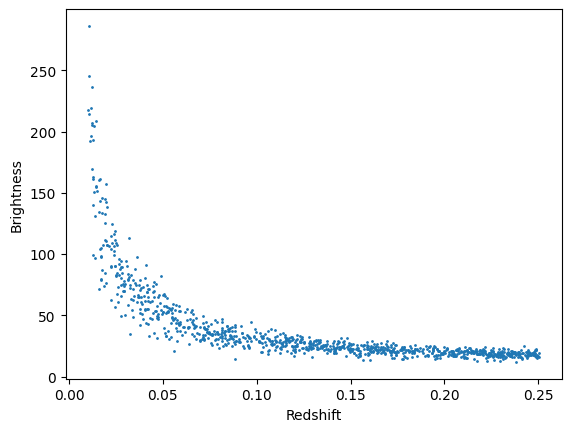

In [3]:
new_data = flow.sample(1000)

plt.scatter(new_data["redshift"], new_data["brightness"], s=1)
plt.xlabel("Redshift")
plt.ylabel("Brightness")
plt.show()

## Loading Saved Flows

The pzflow package provides helper functions to load saved flows from files.  This allows the user to run many simulations with the same model and without having to do a lot of unnecessary re-training.

In [4]:
flow_from_file = Flow(file="../../tests/tdastro/data/test_flow.pkl")
flow_from_file.sample(nsamples=10)

,redshift,brightness
0,0.787938,19.055481
1,4.675078,697.523438
2,4.325153,21.485992
3,9.749113,0.007263
4,0.642965,14.155640
5,6.614377,5.800049
6,9.174571,2.371216
7,9.089792,5.405273
8,7.216269,3.726501
9,5.377309,18.106995


## PZFlow Nodes

To incorporate pzflow models into a simulation's parameter distribution, we need to wrap the flow model in a `ParameterizedNode` object. The `PZFlowNode` class provides a mechanism for using pzflow models as part of the sampling logic. These nodes are function nodes that take (optional) input and generate one or more outputs from the pzflow. The names of output parameters are automatically determined from the underling model.  We can access each column from the node using the same `.` notation as with other other parameters, allowing us to use a consistent set of values from multiple variables.

For example we can create a `PZFlowNode` from the `flow` object defined earlier in this notebook. The constructor analyzes the input flow and determines that there are two outputs "redshift" and "brightness".  These outputs can be used as inputs for later nodes, such as a `ConstantSEDModel`.

In [5]:
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.sources.basic_models import ConstantSEDModel

# Create the pzflow node.
pz_node = PZFlowNode(flow, node_label="pznode")

# Create a static source that draws parameters from the pzflow node.
source = ConstantSEDModel(
    brightness=pz_node.brightness,
    redshift=pz_node.redshift,
    node_label="source",
)

The pznode and any nodes the use it fit seamlessly into the simulation workflow and can be sampled with the normal method (`sample_parameters`). The `PZFlowNode` automatically handles extracting parameters from the resulting Panda's DataFrame and loading them into the appropriate places in the `GraphState`. As expected, all samples from the `PZFlowNode` are consistent, meaning that all parameters for the `i`-th sample are generated together from the pznodes joint distribution.

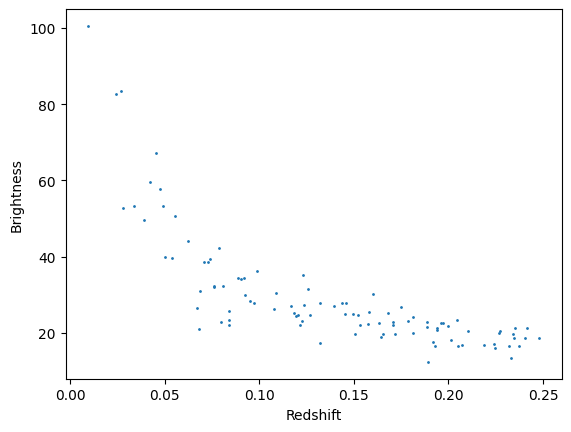

In [6]:
state = source.sample_parameters(num_samples=100)

plt.scatter(state["source"]["redshift"], state["source"]["brightness"], s=1)
plt.xlabel("Redshift")
plt.ylabel("Brightness")
plt.show()

## PZFlow Nodes from Flow Files

The `PZFlowNode` class also provides a helper function to create the node directly from a flow file. This allows a user to access a saved flow without a lot of overhead.

In [7]:
file_node = PZFlowNode.from_file(
    "../../tests/tdastro/data/test_flow.pkl",
    node_label="pznode_from_file",
)

## Conditional Flows in PZFlow

We can construct a conditional flow where the brightness values are conditional on the sampled redshift. In fact our toy data earlier was drawn such that `brightness` depended on `redshift`. We can have pzflow enforce this conditional relationship by breaking the input into tables data columns (which are the output) and conditional columns (which are the input).  The data is generated _conditional_ on the conditional columns.

In [8]:
data = pd.DataFrame({"redshift": redshift, "brightness": brightness})
conditional_flow = Flow(data_columns=["brightness"], conditional_columns=["redshift"])
losses = conditional_flow.train(data, verbose=False)

If we sample from the flow, we see the same distribution of data.  Note that in order to sample this flow we need a pandas table that has the redshift data defined.

The sampling parameters for conditional models are also defined slightly differently. The `conditional_flow.sample(num_samples, conditions=new_data)` will generate `num_samples` for **each** row of `new_data`. In the case of TDAstro, we would like the size of the output to equal the size of the input, so we use 1 sample per input row.

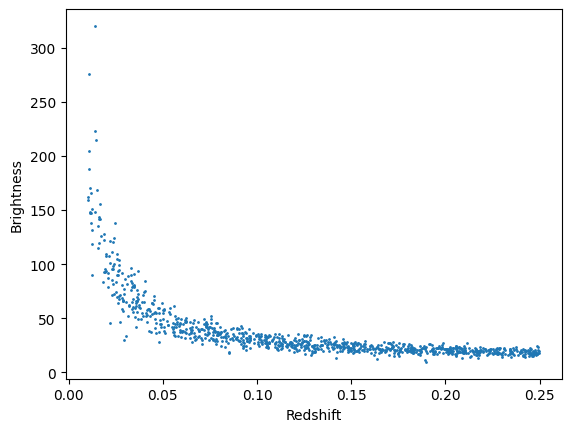

In [9]:
new_redshift = np.random.uniform(0.01, 0.25, size=1000)
new_data = pd.DataFrame({"redshift": new_redshift})
new_data = conditional_flow.sample(1, conditions=new_data)

plt.scatter(new_data["redshift"], new_data["brightness"], s=1)
plt.xlabel("Redshift")
plt.ylabel("Brightness")
plt.show()

Note that the conditional flow above is also saved as tests/tdastro/data/test_conditional_flow.pkl.

## PZFlow Nodes with Conditional Flows

The `PZFlowNode` automatically handles conditional flows without additional set up. The node examines the incoming `Flow` object and determines what information is needed. Each input column **must** be specified as an input parameter for the object.

For example we could sample the redshifts using a random node and then feed that into our conditional pzflow to generate brightnesses.

In [10]:
from tdastro.math_nodes.np_random import NumpyRandomFunc

redshift_node = NumpyRandomFunc(
    "uniform",
    low=0.01,
    high=0.25,
    node_label="redshift_node",
)

brightness_node = PZFlowNode(
    conditional_flow,
    node_label="pzflow_node",
    redshift=redshift_node,  # REQUIRED
)

source2 = ConstantSEDModel(
    brightness=brightness_node.brightness,
    redshift=redshift_node,
    node_label="source2",
)

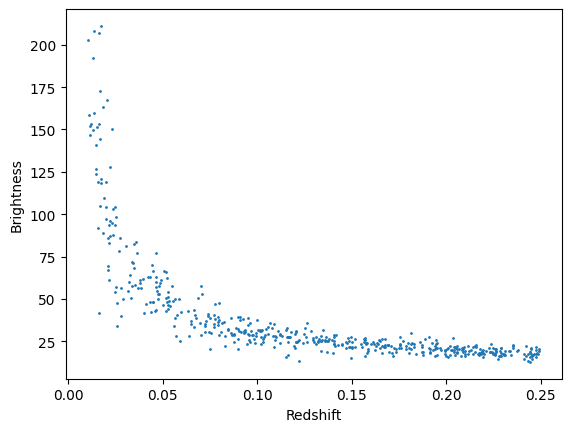

In [11]:
state2 = source2.sample_parameters(num_samples=500)

plt.scatter(state2["source2"]["redshift"], state2["source2"]["brightness"], s=1)
plt.xlabel("Redshift")
plt.ylabel("Brightness")
plt.show()